In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import tqdm
import argparse
import os
import sys
import numpy as np
sys.path.append("..")
from utils import data as dutils
from utils import stimuli as sutils
from utils.data import get_sequences
import matplotlib
import matplotlib.pyplot as plt
import torch.distributions as D
import scienceplots as scp
from matplotlib.ticker import FormatStrFormatter

from baselines import AdaptationModel
from task import fetch_sequences

matplotlib.rcParams['figure.figsize'] = (20, 6)

EPS = 1e-6
PI = torch.acos(torch.zeros(1)).item() * 2

SCRATCH = "./datasets" #"/storage/scratch1/2/asharafeldin3"

seed = np.random.randint(1001, 9999)
print(f"seed = {seed}")

# set a random seed 
torch.manual_seed(seed)
np.random.seed(seed)

seed = 6234


In [2]:
# argument parser 
def parse_args():
    parser = argparse.ArgumentParser()

    """ data paths """
    parser.add_argument("--train_path", type=str, default=SCRATCH + "/train",
                        help="Path to training (familiar) images")
    parser.add_argument("--test_path", type=str, default=SCRATCH + "/test",
                        help="Path to test (novel) images")
    parser.add_argument("--num_train", type=int, default=40,
                        help="Number of training images to use")
    parser.add_argument("--num_test", type=int, default=40,
                        help="Number of test images to use")

    """ sequence setup """
    parser.add_argument("--image_dim", type=int, default=8)
    parser.add_argument("--blank_ts", type=int, default=10,
                        help="Number of blank time steps")
    parser.add_argument("--img_ts", type=int, default=5,
                        help="Number of image time steps")
    parser.add_argument("--num_pres", type=int, default=6,
                        help="Length of sequence, i.e. number of image presentations")
    parser.add_argument("--train_omission_prob", type=float, default=0.0,
                        help="Omission probability for familiar sequences")
    parser.add_argument("--test_omission_prob", type=float, default=0.3,
                        help="Omission probability for novel sequences")

    """ model parameters """
    parser.add_argument("--latent_dim", type=float, default=64)
    parser.add_argument("--h_dim", type=int, default=128)
    parser.add_argument("--lambda_kl", type=float, default=5.0)
    parser.add_argument("--lambda_energy", type=float, default=5.0)
    parser.add_argument("--lambda_reward", type=float, default=0.1)
    parser.add_argument("--nonlinearity", type=str, default="relu")
    parser.add_argument("--device", type=str, default="cuda")

    """ training parameters """
    parser.add_argument("--lr", type=float, default=0.0001)
    parser.add_argument("--num_epochs", type=int, default=200)
    parser.add_argument("--batch_size", type=int, default=32)

    return parser.parse_known_args()[0]

In [3]:
# functions for plotting
def plot_change_responses(args, ax, responses, label, clr, sem=True):
    response_mean = responses.mean([0, -1]).detach()
    response_std = responses.mean(-1).std(0).detach() / np.sqrt(responses.shape[0])
    
    half_blank = args.blank_ts // 2
    
    ax.axvspan(half_blank, half_blank + args.img_ts, color="r", alpha=0.05)
    ax.axvspan(half_blank + args.blank_ts + args.img_ts, half_blank + args.blank_ts + 2 * args.img_ts, color="b", alpha=0.05)
    
    ax.plot(response_mean.numpy(), label=label, color=clr, linewidth=3.0)
    if sem:
        ax.fill_between(np.arange(responses.shape[1]),
                        response_mean - response_std,
                        response_mean + response_std,
                        color=clr, alpha=0.25)

def plot_omission_responses(args, ax, responses, label, image_clr, trace_clr, sem=True):
    response_mean = responses.mean([0, -1]).detach()
    response_std = responses.mean(-1).std(0).detach() / np.sqrt(responses.shape[0])
    
    half_blank = args.blank_ts // 2
    
    # first image
    ax.axvspan(half_blank, half_blank + args.img_ts, color='magenta', alpha=0.05)

    # omitted image
    ax.axvline(args.blank_ts + half_blank + args.img_ts, linestyle="--", color='magenta', linewidth=2.5)
    ax.axvline(args.blank_ts + half_blank + 2 * args.img_ts, linestyle="--", color='magenta', linewidth=2.5)

    # last image
    ax.axvspan(2 * args.blank_ts + half_blank + 2 * args.img_ts,
               2 * args.blank_ts + half_blank + 3 * args.img_ts, color='magenta', alpha=0.05)
    
    ax.plot(response_mean.numpy(), label=label, color=trace_clr, linewidth=3.0)
    if sem:
        ax.fill_between(np.arange(responses.shape[1]),
                        response_mean - response_std,
                        response_mean + response_std,
                        color=trace_clr, alpha=0.25)
        
def raincloud_plot(ax, familiar_responses, novel_responses):

    # Create a list of colors for the boxplots based on the number of features you have
    boxplots_colors = ['darkorange', 'darkblue']
    median_colors = ['orangered', 'navy']

    # Boxplot data
    data = [familiar_responses, novel_responses]
    bp = ax.boxplot(data, patch_artist = True, vert = True, showmeans=True, showfliers=False,
                   meanprops={'markersize': 10, 'markerfacecolor': 'darkgreen'})

    # Change to the desired color and add transparency
    for patch, color in zip(bp['boxes'], boxplots_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.35)
        patch.set_linewidth(2.0)
        patch.set_linestyle('solid')
    
    for patch, color in zip(bp['medians'], median_colors):
        patch.set_color(color)
        patch.set_linewidth(2.5)

    # Create a list of colors for the violin plots based on the number of features you have
    violin_colors = ['orange', 'cornflowerblue']

    # Violinplot data
    vp = ax.violinplot(data, points=500, 
                   showmeans=False, showextrema=False, showmedians=False, vert=True)
    
    for idx, b in enumerate(vp['bodies']):
        # Get the center of the plot
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # Modify it so we only see the upper half of the violin plot
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx+1, idx+2)
        # Change to the desired color
        b.set_color(violin_colors[idx])
        b.set_alpha(0.3)
    

    # Create a list of colors for the scatter plots based on the number of features you have
    scatter_colors = ['darkorange', 'darkblue']

    # Scatterplot data
    for idx, features in enumerate(data):
        # Add jitter effect so the features do not overlap on the y-axis
        y = np.full(len(features), idx + .8)
        idxs = np.arange(len(y))
        out = y.astype(float)
        out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
        y = out
        plt.scatter(y, features, s=10, c=scatter_colors[idx])

    plt.xticks(np.arange(1,3,1), ['Familiar', 'Novel'])  # Set text labels.
    plt.ylabel('Average response')

In [4]:
def get_reward_sequence(batch_size, seq_len, seq_ts,
                        reward_window=6,
                        reward_amount=1.0,
                        action_cost=0.5):
    # for each sequence, creates a reward sequence with the reward an agent gets if it licks at time t
    
    reward_seq = torch.ones((batch_size, seq_len), requires_grad=False) * (-action_cost)
    for s in range(len(reward_seq)):
        
        change_time = seq_ts[s]['after'][0][0]
        reward_seq[s, change_time:change_time+reward_window] = reward_amount - action_cost
    
    return reward_seq

In [5]:
# training functions
def training_epoch(model, dataloader, epoch, optimizer=None, device='cuda'):
    
    pbar = tqdm.tqdm(dataloader, unit='batch')
    pbar.set_description(f"Epoch {epoch}")
    
    for itr, (Y, labels) in enumerate(pbar):
        Y = Y.to(device)
        
        output = model.forward_sequence(Y)
        
        if optimizer is not None:
            optimizer.zero_grad()
            output['MSE'].backward()
            optimizer.step()
            
            pbar.set_postfix(mse=output['MSE'].item())

def train(model, dataloader, num_epochs=10, device='cuda'):
    
    optimizer = None #torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        
        training_epoch(model, dataloader, epoch, optimizer, device)   

In [6]:
# dataset object to hold data
class SequenceDataset(Dataset):
    
    def __init__(self, data_tensor, rewards_tensor):
        self.x = data_tensor
        self.R = rewards_tensor
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.R[idx]

In [7]:
# ---------------------------------------------------------- TRAINING ------------------------------------------------------- #
# parse arguments
args = parse_args()

# train and test sequences
#args.test_omission_prob = 0.0
train_seqs, train_ts, train_oms, test_seqs, test_ts, test_oms = fetch_sequences(args)
y_dim = train_seqs.shape[-1]

# train sequences with omissions (for omission analysis)
args.train_omission_prob = args.test_omission_prob
train_om_seqs, train_om_ts, train_oms, _, _, _ = fetch_sequences(args)

# create reward tensor for train and test sequences
R_train = get_reward_sequence(*train_seqs.shape[:2], train_ts, reward_window=args.img_ts+2)
R_test = get_reward_sequence(*test_seqs.shape[:2], test_ts, reward_window=args.img_ts+2)
R_train_om = get_reward_sequence(*train_seqs.shape[:2], train_om_ts, reward_window=args.img_ts+2)

# TODO: should we normalize images to be between 0 and 1?
Y_train = torch.Tensor(train_seqs).float().to(args.device)
Y_test = torch.Tensor(test_seqs).float()
Y_train_om = torch.Tensor(train_om_seqs).float().to(args.device)

# create data loaders
train_dataset = SequenceDataset(Y_train, R_train)
test_dataset = SequenceDataset(Y_test, R_test)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

# create adaptation model
model = AdaptationModel(num_neurons_E=32,
                        num_neurons_VIP=32,
                        num_neurons_SST=32,
                        num_inputs=Y_train.shape[-1],
                        tau_E=.3,
                        tau_VIP=.3,
                        tau_SST=.3,
                        tau_A=1.,
                        g_E=20.0,
                        g_VIP=20.0,
                        g_SST=10.0,
                        eta=0.00001,
                        alpha=0.001,
                        dt=0.1,
                        hebbian=False,
                        device=args.device).to(args.device)

In [8]:
if model.hebbian:
    train(model, train_dataloader, num_epochs=15, device=args.device)

In [9]:
fam = model.forward_sequence(Y_train.to(args.device))
nov = model.forward_sequence(Y_test.to(args.device))
fam_om = model.forward_sequence(Y_train_om.to(args.device))

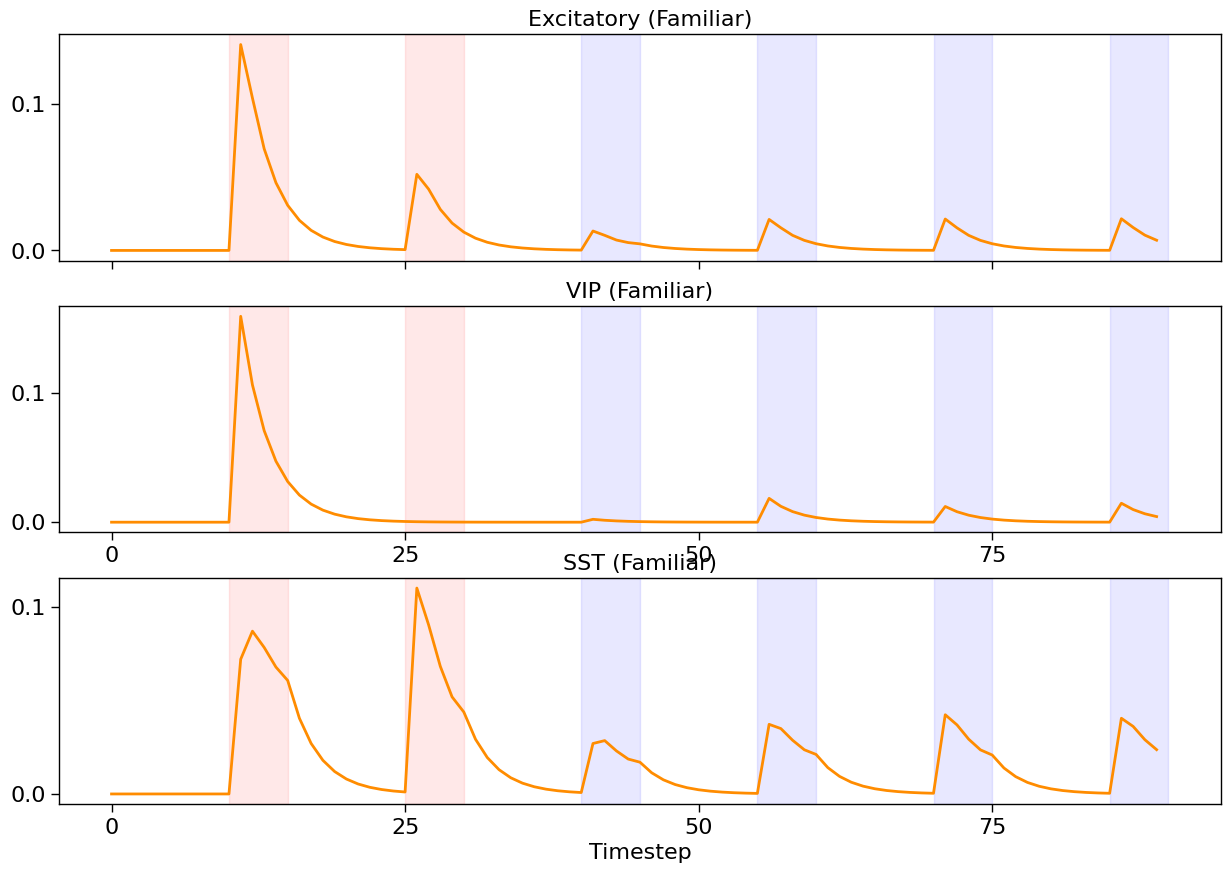

In [10]:
# example sequences (familiar)
train_seq = 0

fig1 = plt.figure(figsize=(15, 10))

with plt.style.context(['nature', 'notebook']):

    ax1 = plt.subplot(3, 1, 1)
    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    
    for bf_on, bf_off in zip(*train_ts[train_seq]['before']):
        ax1.axvspan(bf_on, bf_off, color="r", alpha=0.09)
        ax2.axvspan(bf_on, bf_off, color="r", alpha=0.09)
        ax3.axvspan(bf_on, bf_off, color="r", alpha=0.09)

    for af_on, af_off in zip(*train_ts[train_seq]['after']):
        ax1.axvspan(af_on, af_off, color="b", alpha=0.09)
        ax2.axvspan(af_on, af_off, color="b", alpha=0.09)
        ax3.axvspan(af_on, af_off, color="b", alpha=0.09)

    ax1.plot(fam['E'][train_seq].mean(-1).cpu().detach().numpy(), c='darkorange', label="Familiar", linewidth=2.0)
    ax1.set_title("Excitatory (Familiar)")
    ax1.locator_params('x', nbins=4)
    ax1.locator_params('y', nbins=2)
    
    ax2.plot(fam['VIP'][train_seq].mean(-1).cpu().detach().numpy(), c='darkorange', label="Familiar", linewidth=2.0)
    ax2.set_title("VIP (Familiar)")
    ax2.locator_params('x', nbins=4)
    ax2.locator_params('y', nbins=2)
    
    ax3.plot(fam['SST'][train_seq].mean(-1).cpu().detach().numpy(), c='darkorange', label="Familiar", linewidth=2.0)
    ax3.set_xlabel("Timestep")
    ax3.set_title("SST (Familiar)")
    ax3.locator_params('x', nbins=4)
    ax3.locator_params('y', nbins=2)
    
    
    ax1.tick_params('x', which='both', top=False, labelbottom=False)

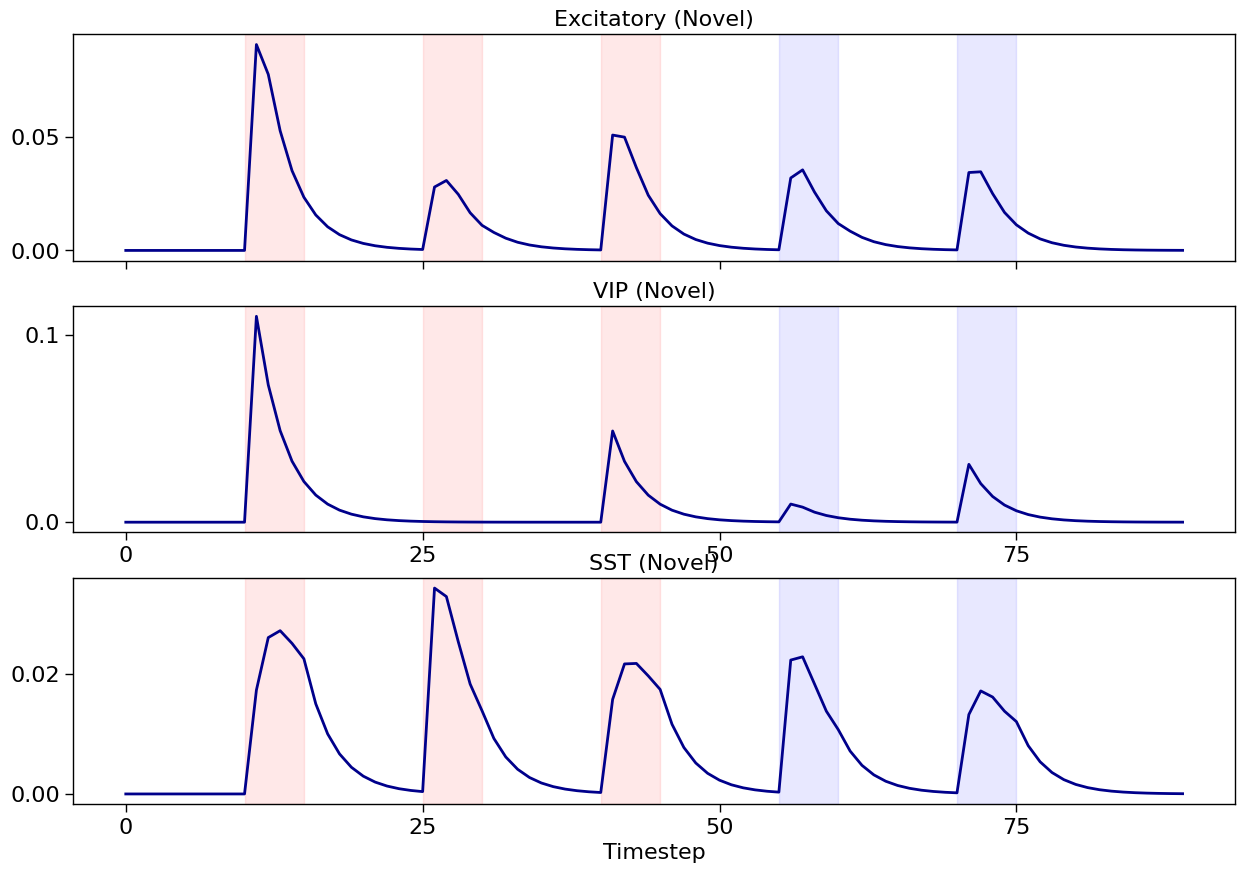

In [11]:
# example sequences (novel)
test_seq = 1

fig1 = plt.figure(figsize=(15, 10))

with plt.style.context(['nature', 'notebook']):

    ax1 = plt.subplot(3, 1, 1)
    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    
    for bf_on, bf_off in zip(*test_ts[test_seq]['before']):
        ax1.axvspan(bf_on, bf_off, color="r", alpha=0.09)
        ax2.axvspan(bf_on, bf_off, color="r", alpha=0.09)
        ax3.axvspan(bf_on, bf_off, color="r", alpha=0.09)

    for af_on, af_off in zip(*test_ts[test_seq]['after']):
        ax1.axvspan(af_on, af_off, color="b", alpha=0.09)
        ax2.axvspan(af_on, af_off, color="b", alpha=0.09)
        ax3.axvspan(af_on, af_off, color="b", alpha=0.09)

    ax1.plot(nov['E'][test_seq].mean(-1).cpu().detach().numpy(), c='darkblue', label="Familiar", linewidth=2.0)
    ax1.set_title("Excitatory (Novel)")
    ax1.locator_params('x', nbins=4)
    ax1.locator_params('y', nbins=2)
    
    ax2.plot(nov['VIP'][test_seq].mean(-1).cpu().detach().numpy(), c='darkblue', label="Familiar", linewidth=2.0)
    ax2.set_title("VIP (Novel)")
    ax2.locator_params('x', nbins=4)
    ax2.locator_params('y', nbins=2)
    
    ax3.plot(nov['SST'][test_seq].mean(-1).cpu().detach().numpy(), c='darkblue', label="Familiar", linewidth=2.0)
    ax3.set_xlabel("Timestep")
    ax3.set_title("SST (Novel)")
    ax3.locator_params('x', nbins=4)
    ax3.locator_params('y', nbins=2)
    
    
    ax1.tick_params('x', which='both', top=False, labelbottom=False)

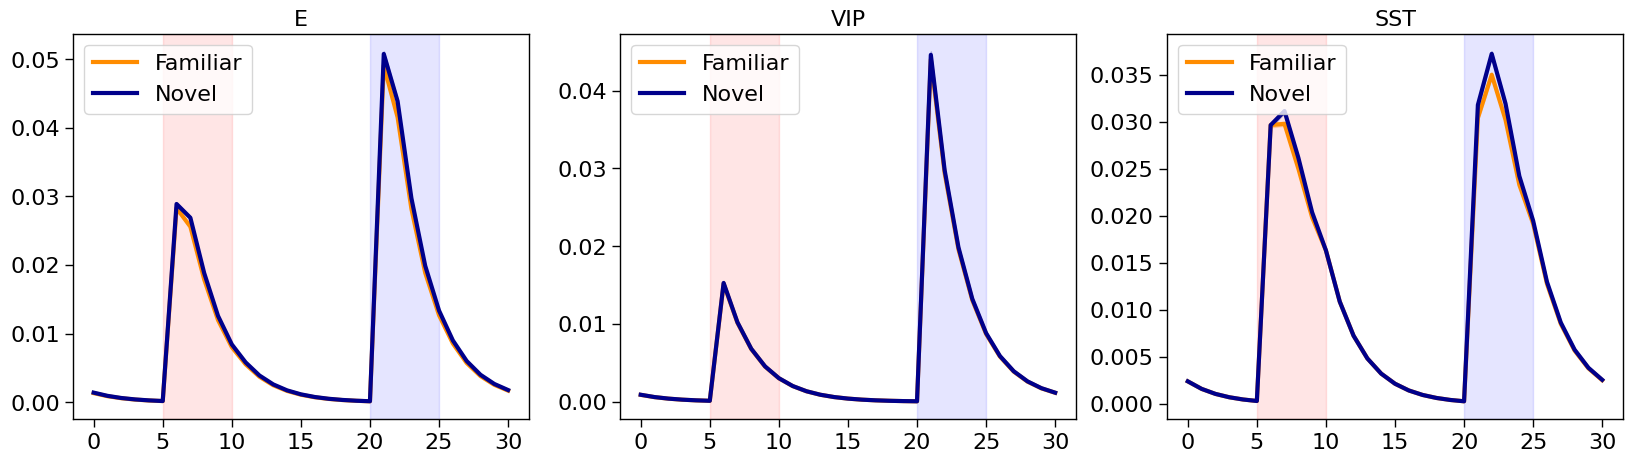

In [12]:
# plot responses around image change

test_no_om_indcs = np.where(np.array(test_oms) <= 0)[0]
num_test_no_omission = len(test_no_om_indcs)

half_blank = args.blank_ts // 2
trial_dur = 2 * half_blank + args.blank_ts + 2 * args.img_ts + 1

e_change_fam = torch.zeros(Y_train.shape[0], trial_dur, fam['E'].shape[-1])
e_change_nov = torch.zeros(num_test_no_omission, trial_dur, nov['E'].shape[-1])

vip_change_fam = torch.zeros(Y_train.shape[0], trial_dur, fam['VIP'].shape[-1])
vip_change_nov = torch.zeros(num_test_no_omission, trial_dur, nov['VIP'].shape[-1])

sst_change_fam = torch.zeros(Y_train.shape[0], trial_dur, fam['SST'].shape[-1])
sst_change_nov = torch.zeros(num_test_no_omission, trial_dur, nov['SST'].shape[-1])

for s in range(Y_train.shape[0]):
    start = train_ts[s]['before'][0][-1] - half_blank
    end = train_ts[s]['after'][1][0] + half_blank + 1
    e_change_fam[s] = fam['E'][s, start:end, :]
    vip_change_fam[s] = fam['VIP'][s, start:end, :]
    sst_change_fam[s] = fam['SST'][s, start:end, :]
    
for si in range(num_test_no_omission):
    s = test_no_om_indcs[si]
    start = test_ts[s]['before'][0][-1] - half_blank
    end = test_ts[s]['after'][1][0] + half_blank + 1
    e_change_nov[si] = nov['E'][s, start:end, :]
    vip_change_nov[si] = nov['VIP'][s, start:end, :]
    sst_change_nov[si] = nov['SST'][s, start:end, :]

with plt.style.context(['nature', 'notebook']):

    fig3 = plt.figure(figsize=(20, 5))
    plt.tight_layout(pad=10, h_pad=5)

    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)

    plot_change_responses(args, ax1, e_change_fam, "Familiar", "darkorange")
    plot_change_responses(args, ax1, e_change_nov, "Novel", "darkblue")
    ax1.set_title("E")
    ax1.legend()
    
    plot_change_responses(args, ax2, vip_change_fam, "Familiar", "darkorange")
    plot_change_responses(args, ax2, vip_change_nov, "Novel", "darkblue")
    ax2.set_title("VIP")
    ax2.legend()
    
    plot_change_responses(args, ax3, sst_change_fam, "Familiar", "darkorange")
    plot_change_responses(args, ax3, sst_change_nov, "Novel", "darkblue")
    ax3.set_title("SST")
    ax3.legend()

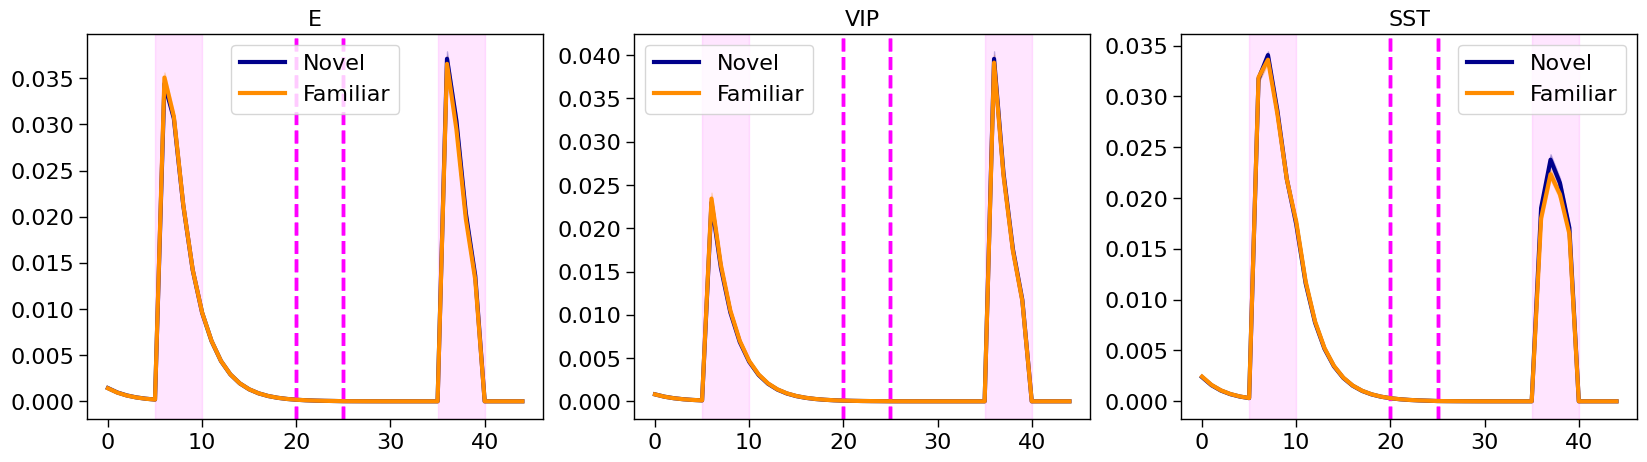

In [13]:
# Plot omission response

test_om_indcs = np.where(np.array(test_oms) > 0)[0]
train_om_indcs = np.where(np.array(train_oms) > 0)[0]

om_trial_dur = 2 * args.blank_ts + 2 * (args.blank_ts // 2) + 3 * args.img_ts

e_fam_om = torch.zeros(len(train_om_indcs), om_trial_dur, fam_om['E'].shape[-1])
vip_fam_om = torch.zeros(len(train_om_indcs), om_trial_dur, fam_om['VIP'].shape[-1])
sst_fam_om = torch.zeros(len(train_om_indcs), om_trial_dur, fam_om['SST'].shape[-1])

e_nov_om = torch.zeros(len(test_om_indcs), om_trial_dur, nov['E'].shape[-1])
vip_nov_om = torch.zeros(len(test_om_indcs), om_trial_dur, nov['VIP'].shape[-1])
sst_nov_om = torch.zeros(len(test_om_indcs), om_trial_dur, nov['SST'].shape[-1])

for si in range(len(train_om_indcs)):

    s = train_om_indcs[si]
    om_ind = train_oms[s]
    start = om_ind - (args.blank_ts + args.blank_ts // 2 + args.img_ts)
    end = om_ind + (args.blank_ts + args.blank_ts // 2 + args.img_ts)
    end = min(end, fam_om['E'].shape[1])
    dur = end - start

    e_fam_om[si, :dur] = fam_om['E'][s, start:end]
    vip_fam_om[si, :dur] = fam_om['VIP'][s, start:end]
    sst_fam_om[si, :dur] = fam_om['SST'][s, start:end]


for si in range(len(test_om_indcs)):

    s = test_om_indcs[si]
    om_ind = test_oms[s]
    start = om_ind - (args.blank_ts + args.blank_ts // 2 + args.img_ts)
    end = om_ind + (args.blank_ts + args.blank_ts // 2 + args.img_ts)
    end = min(end, nov['E'].shape[1])
    dur = end - start

    e_nov_om[si, :dur] = nov['E'][s, start:end]
    vip_nov_om[si, :dur] = nov['VIP'][s, start:end]
    sst_nov_om[si, :dur] = nov['SST'][s, start:end]


with plt.style.context(['nature', 'notebook']):

    fig4 = plt.figure(figsize=(20, 5))
    plt.tight_layout(pad=10, h_pad=5)

    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)

    
    plot_omission_responses(args, ax1, e_nov_om, "Novel", trace_clr="darkblue", image_clr="magenta", sem=True)
    plot_omission_responses(args, ax1, e_fam_om, "Familiar", trace_clr="darkorange", image_clr="magenta", sem=True)
    ax1.set_title("E")
    ax1.legend()
    
    plot_omission_responses(args, ax2, vip_nov_om, "Novel", trace_clr="darkblue", image_clr="magenta", sem=True)
    plot_omission_responses(args, ax2, vip_fam_om, "Familiar", trace_clr="darkorange", image_clr="magenta", sem=True)
    ax2.set_title("VIP")
    ax2.legend()
    
    plot_omission_responses(args, ax3, sst_nov_om, "Novel", trace_clr="darkblue", image_clr="magenta", sem=True)
    plot_omission_responses(args, ax3, sst_fam_om, "Familiar", trace_clr="darkorange", image_clr="magenta", sem=True)
    ax3.set_title("SST")
    ax3.legend()

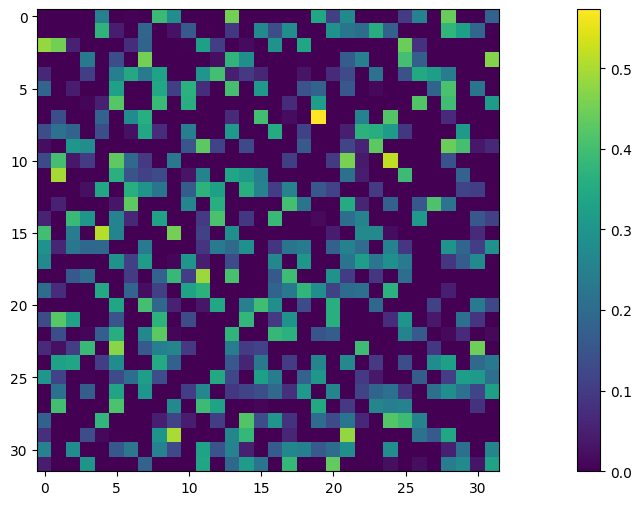

In [14]:
plt.imshow(model.E_to_VIP.weight.data.cpu().detach().numpy())
plt.colorbar()